# Task 1

### 1.2. & 1.3. Replicating Figure 1 from GK, model estimation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

plt.rc("font", size=11)
plt.rc("axes", titlesize=11)

VAR sample: 1979-07-01 00:00:00 to 2012-06-01 00:00:00
Number of observations: 396
Proxy first-stage F = 21.517004333823614 nobs = 270


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

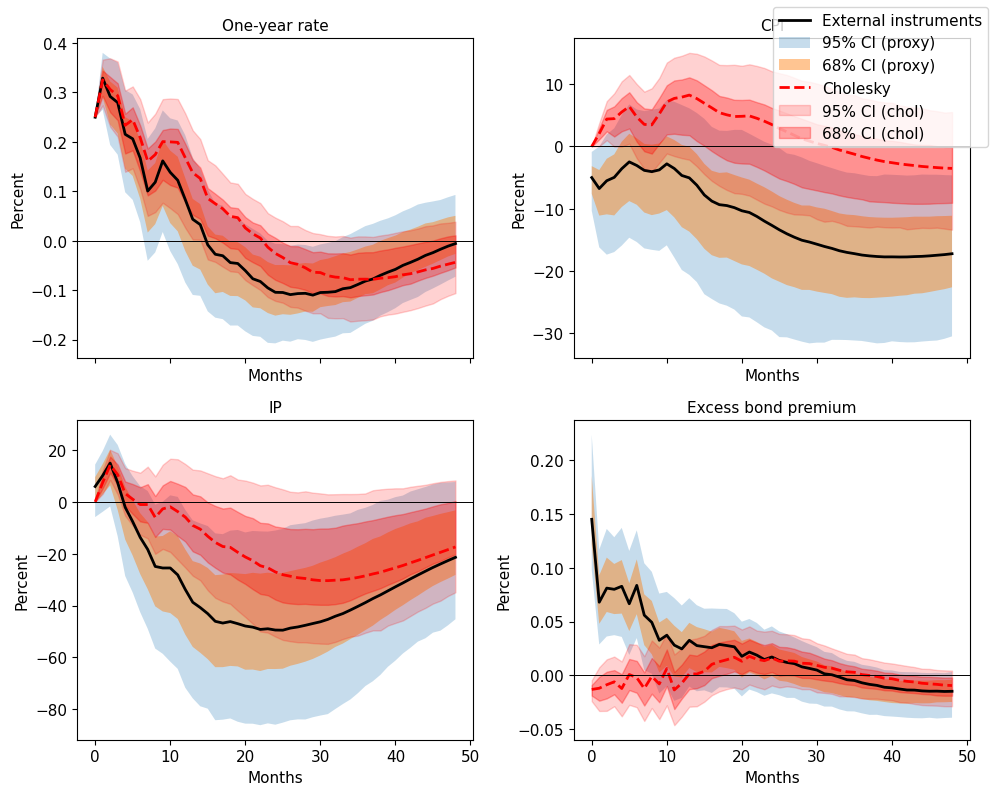

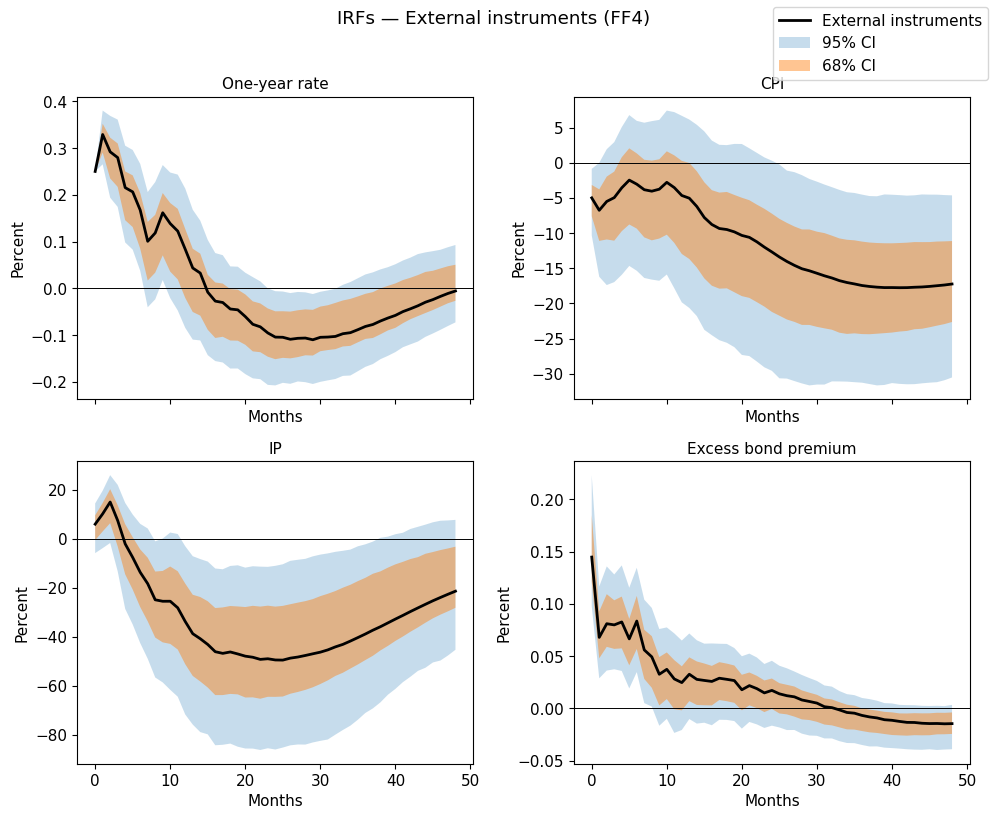

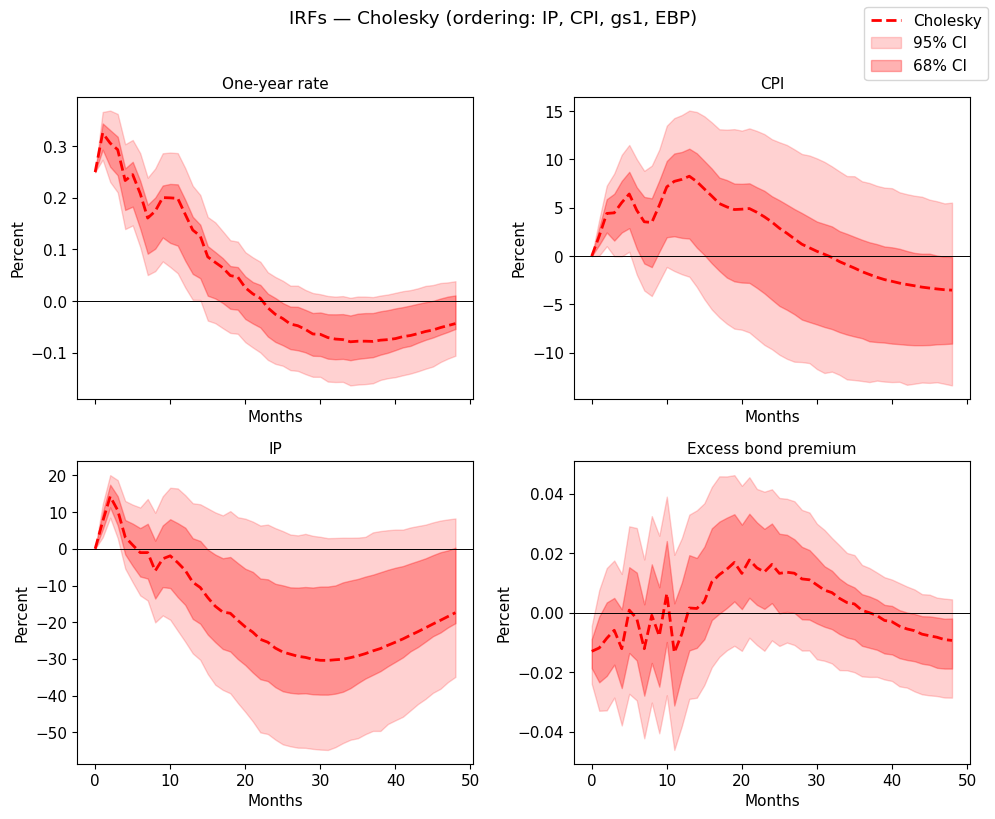

In [4]:
# ============================================================
# Proxy-SVAR (external instrument) vs Cholesky IRFs
# + Bootstrap percentile CIs for BOTH (proxy and Cholesky)
# ============================================================

class GKProxyCholIRF:
    """
    Replication-style helper:
      - proxy_svar_identification (external instrument)
      - structural IRFs from impact vector
      - wild bootstrap CIs for proxy IRFs
      - wild bootstrap CIs for Cholesky orth IRFs (NEW)
      - plot function with BOTH CIs on the same panels
    """

    def __init__(self, p=12, irhor=48, clevels=(68, 95), shock_size=0.25, policy_var="gs1"):
        self.p = int(p)
        self.irhor = int(irhor)
        self.clevels = tuple(clevels)
        self.shock_size = float(shock_size)
        self.policy_var = str(policy_var)

    # -------------------------
    # Identification (Proxy-SVAR)
    # -------------------------
    def proxy_svar_identification(self, var_res, instrument_series):
        """
        External-instrument identification (Mertens-Ravn / GK-style).

        Returns dict with:
          - impact_vector (s): normalized so that impact on policy residual is 1
          - diagnostics: first-stage stats, nobs, etc.
        """
        resid = var_res.resid.copy()  # DataFrame, index aligned to effective VAR sample
        z = instrument_series.rename("z")

        data = resid.join(z, how="inner").dropna(subset=["z"])
        U = data[resid.columns].to_numpy()
        Z = data["z"].to_numpy()

        # Demean
        Z_dm = Z - Z.mean()
        U_dm = U - U.mean(axis=0)

        # Cov(u, z)
        cov_uz = (U_dm * Z_dm[:, None]).mean(axis=0)

        cols = list(resid.columns)
        if self.policy_var not in cols:
            raise ValueError(f"policy_var='{self.policy_var}' not in VAR residual columns: {cols}")

        policy_idx = cols.index(self.policy_var)

        # Normalize so that impact on policy residual = 1
        denom = cov_uz[policy_idx]
        if np.isclose(denom, 0.0):
            # Weak or invalid instrument -> still return something but flag it
            s = np.full_like(cov_uz, np.nan, dtype=float)
        else:
            s = cov_uz / denom

        # First-stage regression diagnostics: u_policy on [1, z]
        X = sm.add_constant(Z_dm)
        y = U_dm[:, policy_idx]
        ols_res = sm.OLS(y, X).fit()

        diagnostics = {
            "policy_index": policy_idx,
            "n_obs": int(len(Z_dm)),
            "beta": float(ols_res.params[1]) if len(ols_res.params) > 1 else np.nan,
            "t_beta": float(ols_res.tvalues[1]) if len(ols_res.tvalues) > 1 else np.nan,
            "F": float(ols_res.fvalue) if ols_res.fvalue is not None else np.nan,
            "pval_F": float(ols_res.f_pvalue) if ols_res.f_pvalue is not None else np.nan,
            "R2": float(ols_res.rsquared),
        }

        return {"impact_vector": s, "diagnostics": diagnostics}

    # -------------------------
    # Structural IRFs from impact vector
    # -------------------------
    @staticmethod
    def _irfs_from_var(var_res, impact_vector, horizon):
        """
        Companion-form IRFs to a 1-unit structural shock with impact vector (nvars,).
        Returns (horizon+1, nvars).
        """
        coefs = var_res.coefs  # (p, n, n)
        p, n, _ = coefs.shape
        k = n * p

        F = np.zeros((k, k))
        F[:n, : n * p] = np.hstack([coefs[i] for i in range(p)])
        if p > 1:
            F[n:, :-n] = np.eye(n * (p - 1))

        G = np.zeros((k, n))
        G[:n, :] = np.eye(n)

        shock = np.asarray(impact_vector, dtype=float).reshape(n, 1)
        state = G @ shock

        irfs = np.zeros((horizon + 1, n))
        irfs[0, :] = state[:n, 0]
        for h in range(1, horizon + 1):
            state = F @ state
            irfs[h, :] = state[:n, 0]
        return irfs

    def calculate_structural_irfs(self, var_res, impact_vector):
        """
        IRFs normalized to a 1-unit policy shock (impact response of policy variable = 1),
        then scaled to self.shock_size (e.g., 0.25 pp on impact of policy rate).
        """
        cols = list(var_res.names)
        policy_idx = cols.index(self.policy_var)

        irfs_raw = self._irfs_from_var(var_res, impact_vector, self.irhor)

        # Normalize so policy impact = 1
        denom = irfs_raw[0, policy_idx]
        if np.isclose(denom, 0.0) or np.isnan(denom):
            irfs_unit = np.full_like(irfs_raw, np.nan)
        else:
            irfs_unit = irfs_raw / denom

        return irfs_unit * self.shock_size

    # -------------------------
    # Cholesky IRFs (extract policy shock)
    # -------------------------
    def cholesky_irfs(self, var_res):
        """
        Uses statsmodels orthogonalized IRFs (Cholesky with ordering as in VAR).
        Returns (H+1, nvars) scaled to self.shock_size on policy impact.
        """
        cols = list(var_res.names)
        policy_idx = cols.index(self.policy_var)

        orth = var_res.irf(self.irhor).orth_irfs  # (H+1, nvars, nvars)
        irfs_raw = orth[:, :, policy_idx]         # response of all vars to policy shock

        # Normalize to unit policy shock (impact = 1), then scale
        denom = irfs_raw[0, policy_idx]
        if np.isclose(denom, 0.0) or np.isnan(denom):
            irfs_unit = np.full_like(irfs_raw, np.nan)
        else:
            irfs_unit = irfs_raw / denom

        return irfs_unit * self.shock_size

    # -------------------------
    # Wild bootstrap: Proxy-SVAR
    # -------------------------
    def recursive_bootstrap_proxy_svar(self, Y, instrument_series, var_res_base=None, n_boot=1000, seed=123):
        """
        Wild bootstrap draws for PROXY IRFs (already scaled to self.shock_size).
        Returns boot_irfs: (n_boot, H+1, nvars)
        """
        rng = np.random.default_rng(seed)

        if var_res_base is None:
            var_res_base = VAR(Y).fit(self.p)

        resid = var_res_base.resid
        coefs = var_res_base.coefs
        const = var_res_base.intercept

        T = len(Y)
        n = Y.shape[1]
        idx_Y = Y.index

        cols = list(Y.columns)
        policy_idx = cols.index(self.policy_var)

        # Align instrument to residual index (effective VAR sample)
        z_resid = instrument_series.reindex(resid.index)

        boot = np.zeros((n_boot, self.irhor + 1, n))

        for b in range(n_boot):
            signs = rng.choice([-1.0, 1.0], size=len(resid))
            eps_b = resid.to_numpy() * signs[:, None]

            # simulate
            Yb = np.zeros((T, n))
            Yb[: self.p, :] = Y.to_numpy()[: self.p, :]

            for t in range(self.p, T):
                yhat = const.copy()
                for lag in range(self.p):
                    yhat += coefs[lag] @ Yb[t - 1 - lag, :]
                Yb[t, :] = yhat + eps_b[t - self.p, :]

            Yb_df = pd.DataFrame(Yb, index=idx_Y, columns=cols)
            res_b = VAR(Yb_df).fit(self.p)

            # sign-flip instrument consistently
            zb = z_resid * signs

            proxy_b = self.proxy_svar_identification(res_b, zb)
            s_b = proxy_b["impact_vector"]

            irfs_b_raw = self._irfs_from_var(res_b, s_b, self.irhor)

            # normalize to unit policy shock, scale to shock_size
            denom = irfs_b_raw[0, policy_idx]
            if np.isclose(denom, 0.0) or np.isnan(denom):
                boot[b, :, :] = np.nan
            else:
                boot[b, :, :] = (irfs_b_raw / denom) * self.shock_size

        return boot

    # -------------------------
    # Wild bootstrap: Cholesky
    # -------------------------
    def recursive_bootstrap_cholesky(self, Y, var_res_base=None, n_boot=1000, seed=123):
        """
        Wild bootstrap draws for CHOLESKY IRFs (already scaled to self.shock_size).
        Returns boot_irfs: (n_boot, H+1, nvars)
        """
        rng = np.random.default_rng(seed)
        if var_res_base is None:
            var_res_base = VAR(Y).fit(self.p)

        resid = var_res_base.resid
        coefs = var_res_base.coefs
        const = var_res_base.intercept

        T = len(Y)
        n = Y.shape[1]
        idx_Y = Y.index

        cols = list(Y.columns)
        policy_idx = cols.index(self.policy_var)

        boot = np.zeros((n_boot, self.irhor + 1, n))

        for b in range(n_boot):
            signs = rng.choice([-1.0, 1.0], size=len(resid))
            eps_b = resid.to_numpy() * signs[:, None]

            # simulate
            Yb = np.zeros((T, n))
            Yb[: self.p, :] = Y.to_numpy()[: self.p, :]

            for t in range(self.p, T):
                yhat = const.copy()
                for lag in range(self.p):
                    yhat += coefs[lag] @ Yb[t - 1 - lag, :]
                Yb[t, :] = yhat + eps_b[t - self.p, :]

            Yb_df = pd.DataFrame(Yb, index=idx_Y, columns=cols)
            res_b = VAR(Yb_df).fit(self.p)

            orth = res_b.irf(self.irhor).orth_irfs        # (H+1, nvars, nvars)
            irfs_b_raw = orth[:, :, policy_idx]           # (H+1, nvars)

            denom = irfs_b_raw[0, policy_idx]
            if np.isclose(denom, 0.0) or np.isnan(denom):
                boot[b, :, :] = np.nan
            else:
                boot[b, :, :] = (irfs_b_raw / denom) * self.shock_size

        return boot

    # -------------------------
    # Percentile CIs
    # -------------------------
    @staticmethod
    def percentile_cis(boot_irfs, levels=(68, 95)):
        """
        boot_irfs: (nboot, H+1, nvars)
        returns dict: level -> (lower, upper) each (H+1, nvars)
        """
        boot = np.asarray(boot_irfs, dtype=float)
        cis = {}
        for level in levels:
            alpha = 1 - level / 100.0
            lower = np.nanquantile(boot, alpha / 2.0, axis=0)
            upper = np.nanquantile(boot, 1 - alpha / 2.0, axis=0)
            cis[level] = (lower, upper)
        return cis

    # -------------------------
    # Plot (GK Figure 1 style) with both CIs
    # -------------------------
    def plot_figure1_final(self, proxy_irfs, chol_irfs, proxy_boot, chol_boot, proxy_results):
        """
        proxy_irfs, chol_irfs: (H+1, nvars) already scaled
        proxy_boot, chol_boot: (nboot, H+1, nvars) already scaled
        proxy_results: dict from proxy_svar_identification (for diagnostics text if needed)
        """
        cols = list(proxy_results.get("var_names", []))  # optional
        # If not provided, infer from shapes later outside; we will use Y columns when calling this.

        cis_proxy = self.percentile_cis(proxy_boot, levels=self.clevels)
        cis_chol  = self.percentile_cis(chol_boot,  levels=self.clevels)

        h = np.arange(self.irhor + 1)

        # Panel setup (GK order)
        panel_vars   = ["gs1", "logcpi", "logip", "ebp"]
        panel_titles = ["One-year rate", "CPI", "IP", "Excess bond premium"]

        fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
        axes = axes.ravel()

        # Need var name -> column index mapping; assume your Y has these columns in this order
        # So we store mapping on the instance at call time (see run block below).
        cols_map = self._cols_map

        scaling = {"gs1": 1.0, "ebp": 1.0, "logip": 100.0, "logcpi": 100.0}

        # unpack CIs
        # For two levels (68,95) we plot both.
        # We'll plot the higher level lighter, lower level darker.
        levels_sorted = sorted(self.clevels)
        lo_hi_proxy = {lvl: cis_proxy[lvl] for lvl in levels_sorted}
        lo_hi_chol  = {lvl: cis_chol[lvl]  for lvl in levels_sorted}

        for ax, var, title in zip(axes, panel_vars, panel_titles):
            j = cols_map[var]
            s = scaling[var]

            # Proxy line
            ax.plot(h, s * proxy_irfs[:, j], lw=2, color="black",
                    label="External instruments" if var == "gs1" else None)
            # Proxy bands
            for lvl in reversed(levels_sorted):  # 95 first (lighter), 68 second (darker)
                lo, hi = lo_hi_proxy[lvl]
                alpha = 0.25 if lvl == max(levels_sorted) else 0.45
                ax.fill_between(
                    h, s * lo[:, j], s * hi[:, j],
                    alpha=alpha,
                    label=f"{lvl}% CI (proxy)" if var == "gs1" else None
                )

            # Cholesky line
            ax.plot(h, s * chol_irfs[:, j], lw=2, ls="--", color="red",
                    label="Cholesky" if var == "gs1" else None)

            # Cholesky bands (red-tinted)
            for lvl in reversed(levels_sorted):
                lo, hi = lo_hi_chol[lvl]
                alpha = 0.18 if lvl == max(levels_sorted) else 0.30
                ax.fill_between(
                    h, s * lo[:, j], s * hi[:, j],
                    alpha=alpha, color="red",
                    label=f"{lvl}% CI (chol)" if var == "gs1" else None
                )

            ax.axhline(0, lw=0.7, color="black")
            ax.set_title(title)
            ax.set_xlabel("Months")
            ax.set_ylabel("Percent")

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper right")
        fig.tight_layout()
        return fig

    def _setup_panels(self):
        panel_vars   = ["gs1", "logcpi", "logip", "ebp"]
        panel_titles = ["One-year rate", "CPI", "IP", "Excess bond premium"]
        scaling = {"gs1": 1.0, "ebp": 1.0, "logip": 100.0, "logcpi": 100.0}
        return panel_vars, panel_titles, scaling

    def plot_proxy_only(self, proxy_irfs, proxy_boot, proxy_results=None, title=None):
        """
        proxy_irfs: (H+1, nvars) scaled
        proxy_boot: (nboot, H+1, nvars) scaled
        """
        cis_proxy = self.percentile_cis(proxy_boot, levels=self.clevels)
        levels_sorted = sorted(self.clevels)

        h = np.arange(self.irhor + 1)
        panel_vars, panel_titles, scaling = self._setup_panels()
        cols_map = self._cols_map

        fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
        axes = axes.ravel()

        for ax, var, ttl in zip(axes, panel_vars, panel_titles):
            j = cols_map[var]
            s = scaling[var]

            # line
            ax.plot(h, s * proxy_irfs[:, j], lw=2, color="black",
                    label="External instruments" if var == "gs1" else None)

            # bands (95 lighter, 68 darker)
            for lvl in reversed(levels_sorted):
                lo, hi = cis_proxy[lvl]
                alpha = 0.25 if lvl == max(levels_sorted) else 0.45
                ax.fill_between(
                    h, s * lo[:, j], s * hi[:, j],
                    alpha=alpha,
                    label=f"{lvl}% CI" if var == "gs1" else None
                )

            ax.axhline(0, lw=0.7, color="black")
            ax.set_title(ttl)
            ax.set_xlabel("Months")
            ax.set_ylabel("Percent")

        if title is None:
            title = "IRFs — External Instruments"
        fig.suptitle(title, y=1.02)

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper right")
        fig.tight_layout()
        return fig

    def plot_cholesky_only(self, chol_irfs, chol_boot, title=None):
        """
        chol_irfs: (H+1, nvars) scaled
        chol_boot: (nboot, H+1, nvars) scaled
        """
        cis_chol = self.percentile_cis(chol_boot, levels=self.clevels)
        levels_sorted = sorted(self.clevels)

        h = np.arange(self.irhor + 1)
        panel_vars, panel_titles, scaling = self._setup_panels()
        cols_map = self._cols_map

        fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
        axes = axes.ravel()

        for ax, var, ttl in zip(axes, panel_vars, panel_titles):
            j = cols_map[var]
            s = scaling[var]
            # line
            ax.plot(h, s * chol_irfs[:, j], lw=2, color="red", ls="--",
                    label="Cholesky" if var == "gs1" else None)

            # bands (95 lighter, 68 darker)
            for lvl in reversed(levels_sorted):
                lo, hi = cis_chol[lvl]
                alpha = 0.18 if lvl == max(levels_sorted) else 0.30
                ax.fill_between(
                    h, s * lo[:, j], s * hi[:, j],
                    alpha=alpha, color="red",
                    label=f"{lvl}% CI" if var == "gs1" else None
                )

            ax.axhline(0, lw=0.7, color="black")
            ax.set_title(ttl)
            ax.set_xlabel("Months")
            ax.set_ylabel("Percent")

        if title is None:
            title = "IRFs — Cholesky"
        fig.suptitle(title, y=1.02)

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper right")
        fig.tight_layout()
        return fig



# ---- Using our data ----
var_data = pd.read_csv("VAR_data.csv")
factor_data = pd.read_csv("factor_data.csv")

for df in (var_data, factor_data):
    df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
    df.set_index("date", inplace=True)

start, end = "1979-07-01", "2012-06-01"
var_cols = ["logip", "logcpi", "gs1", "ebp"]

Y = var_data.loc[start:end, var_cols].copy()

Z_ff4 = factor_data.loc[start:end, "ff4_tc"]

print("VAR sample:", Y.index[0], "to", Y.index[-1])
print("Number of observations:", len(Y))

# ---- 1) Estimate VAR ----
p = 12
irhor = 48
model = VAR(Y)
var_res = model.fit(p)

# ---- 2) Init replicator ----
rep = GKProxyCholIRF(p=p, irhor=irhor, clevels=(68, 95), shock_size=0.25, policy_var="gs1")

rep._cols_map = {name: i for i, name in enumerate(Y.columns)}

# ============================================================
# A) Baseline demo: instrument FF4 vs Cholesky (works standalone)
# ============================================================

proxy_results = rep.proxy_svar_identification(var_res, Z_ff4)
print("Proxy first-stage F =", proxy_results["diagnostics"]["F"], "nobs =", proxy_results["diagnostics"]["n_obs"])

proxy_irfs = rep.calculate_structural_irfs(var_res, proxy_results["impact_vector"])
chol_irfs  = rep.cholesky_irfs(var_res)

nboot = 1000
proxy_boot = rep.recursive_bootstrap_proxy_svar(Y, Z_ff4, var_res_base=var_res, n_boot=nboot, seed=123)
chol_boot  = rep.recursive_bootstrap_cholesky(Y, var_res_base=var_res, n_boot=nboot, seed=123)

proxy_results["var_names"] = list(Y.columns)

fig = rep.plot_figure1_final(proxy_irfs, chol_irfs, proxy_boot, chol_boot, proxy_results)
plt.show()

# 2) chol + bootstrap
fig_proxy = rep.plot_proxy_only(proxy_irfs, proxy_boot, title="IRFs — External instruments (FF4)")
fig_chol  = rep.plot_cholesky_only(chol_irfs, chol_boot, title="IRFs — Cholesky (ordering: IP, CPI, gs1, EBP)")

plt.show()


In [5]:
proxy_results["impact_vector"] # impact vector

array([ 0.23704659, -0.19995323,  1.        ,  0.57931832])

**Comments:**

**1.2.** We have estimated 4-variable monthly VAR (IP, CPI, One-year rate, Excess bond premium) over 1979-2012 using the original data from GK article. FF4 was used as an external instrument for Proxy-SVAR identification. We computed IRFs for both External Intruments and Cholesky (confidence intervals were built only for External Intruments to combine graphs so that the differences between models would be more clear). For CPI and IP the scale waas normalized. ***As can be observed, graphs are almost identical to the original paper.***

**1.3.a.** First-stage F-statistic is **21.52** (close to the paper – it was 21.55) > 12 -> the instrument is relevant. By looking at the impact vector, we can estimate the effect of MP tightening (+25 bp in gs1) on each variable:

*   IP: +0.24 – output jumps immediately;
*   CPI: -0.20 – prices fall;
*   gs1: +1 – by construction;
*   EBP: +0.58 – immediate financial tightening (financial intermediaries become more risk‑averse and credit conditions tighten).

These findings confirm GR results: positive IP and negative CPI are standart for Proxy-SVAR models, high EBP validates that monetary policy shocks propagate not only through short-rate, but also via tightening of credit spreads and risk premia.

**1.3.b.** Ordering in Cholesky identification is crucial to determine how variables' shocks can affect each other. We determine this order: IP -> CPI -> one-year rate -> excess bond premium. Logic: real macro variables cannot immediately react on monetary shock (production changes for week/months, prices for weeks after shock), rate itself reacts immediately (by construction we change rate) and it affects financial market with some short lag. So for monetary shock for IP and CPI reaction in the period of the shock should be zero for Cholesky, and non-zero for External instrument (and it holds for our graphs: for IP and CPI red line (Cholesky) starts at zero, while black line (External Instruments) does not.
Comparing IRFs for Cholesky and Proxy-SVAR, we can see that graphs show similar patterns in responses (IP, CPI decline; EBP rises shortly and then decline), but Cholesky's responses are smaller in magnitude and more conservative. Proxy-SVAR model can be more preferable as it does not impose such strict restrictions on ordering, but can show sighnificant dynamic due to relevant instrument.

### 1.4. Plots for Scheduled vs Unscheduled vs all FOMC


--- Scheduled vs Unscheduled FOMC instruments ---
First-stage F (all)        = 0.8290670271714785
First-stage F (scheduled)  = 1.9969782792683608
First-stage F (unscheduled)= 12.06241534053459


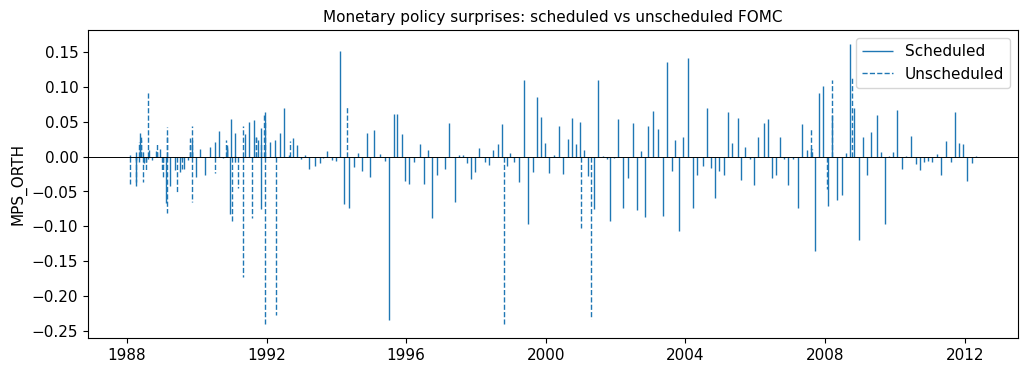

In [6]:
# Scheduled vs Unscheduled vs all FOMC instruments
print("\n--- Scheduled vs Unscheduled FOMC instruments ---")

xls = pd.ExcelFile("monetary-policy-surprises-data.xlsx")
fomc = pd.read_excel(xls, sheet_name="FOMC (update 2023)")

fomc["Date"] = pd.to_datetime(fomc["Date"])
fomc["ym"] = fomc["Date"].dt.to_period("M")
fomc["type"] = np.where(fomc["Unscheduled"] == 1, "unscheduled", "scheduled")
fomc["MPS_ORTH"] = pd.to_numeric(fomc["MPS_ORTH"], errors="coerce")

fomc_sub = fomc[(fomc["Date"] >= start) & (fomc["Date"] <= end)]

monthly_all = fomc_sub.groupby("ym")["MPS_ORTH"].sum().to_frame("MPS_all")
monthly_sched = (
    fomc_sub[fomc_sub["type"] == "scheduled"]
    .groupby("ym")["MPS_ORTH"].sum()
    .to_frame("MPS_sched")
)
monthly_unsched = (
    fomc_sub[fomc_sub["type"] == "unscheduled"]
    .groupby("ym")["MPS_ORTH"].sum()
    .to_frame("MPS_unsched")
)

monthly_instr = (
    monthly_all
    .join(monthly_sched, how="outer")
    .join(monthly_unsched, how="outer")
    .fillna(0.0)
)
monthly_instr.index = monthly_instr.index.to_timestamp(how="start")

Z_all     = monthly_instr["MPS_all"]
Z_sched   = monthly_instr["MPS_sched"]
Z_unsched = monthly_instr["MPS_unsched"]

# Proxy-SVAR identification (using class methods)
proxy_all   = rep.proxy_svar_identification(var_res, Z_all)
proxy_sched = rep.proxy_svar_identification(var_res, Z_sched)
proxy_uns   = rep.proxy_svar_identification(var_res, Z_unsched)

s_all     = proxy_all["impact_vector"]
s_sched   = proxy_sched["impact_vector"]
s_unsched = proxy_uns["impact_vector"]

diag_all     = proxy_all["diagnostics"]
diag_sched   = proxy_sched["diagnostics"]
diag_unsched = proxy_uns["diagnostics"]

print("First-stage F (all)        =", diag_all["F"])
print("First-stage F (scheduled)  =", diag_sched["F"])
print("First-stage F (unscheduled)=", diag_unsched["F"])

# IRFs to each structural shock, scaled to rep.shock_size
irfs_all     = rep.calculate_structural_irfs(var_res, s_all)
irfs_sched   = rep.calculate_structural_irfs(var_res, s_sched)
irfs_unsched = rep.calculate_structural_irfs(var_res, s_unsched)

# Event plot of scheduled vs unscheduled surprises
fig, ax = plt.subplots(figsize=(12, 4))
sched = fomc_sub[fomc_sub["type"] == "scheduled"]
unsched = fomc_sub[fomc_sub["type"] == "unscheduled"]

ax.vlines(sched["Date"], 0, sched["MPS_ORTH"], linewidth=1, label="Scheduled")
ax.vlines(
    unsched["Date"],
    0,
    unsched["MPS_ORTH"],
    linewidth=1,
    linestyles="dashed",
    label="Unscheduled",
)
ax.axhline(0, lw=0.7, color="black")
ax.set_ylabel("MPS_ORTH")
ax.set_title("Monetary policy surprises: scheduled vs unscheduled FOMC")
ax.legend()
plt.show()


**Comment:** by looking at the graph, we can see that scheduled FOMC meetings occur more frequently, but the magnitude of monetary surprises (MPS_ORTH) varies significantly across events. Unscheduled meetings are rarer, yet they tend to generate larger impacts (taller bars), particularly for negative surprises corresponding to monetary policy easing.

This pattern aligns with F-statistic: only for Unscheduled event F-stat = 12.06 > 12 -> stronger instrument that we should use in our analysis. These results are consistent with theory as unscheduled FOCM meetings can generate larger monetary surprises due to lower information leakage before meeting.

### 1.5. Replicating Figure 1, but using Sceduled and Unsceduled FOMC meetings

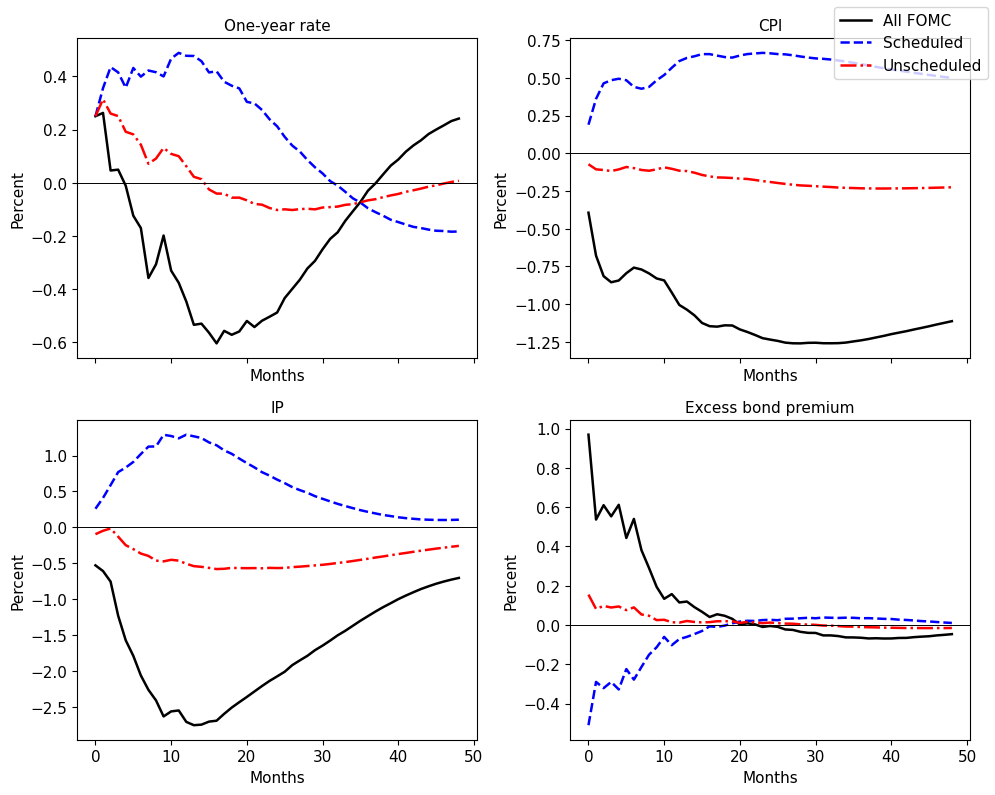

In [8]:
# IRFs: all vs scheduled vs unscheduled FOMC instruments
panel_vars   = ["gs1", "logcpi", "logip", "ebp"]
panel_titles = ["One-year rate", "CPI", "IP", "Excess bond premium"]
scaling      = {"gs1": 1.0, "ebp": 1.0, "logip": 1.0, "logcpi": 1.0}

h = np.arange(rep.irhor + 1)
cols_map = rep._cols_map  # {var_name: index}

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.ravel()

for ax, var, title in zip(axes, panel_vars, panel_titles):
    j = cols_map[var]
    s = scaling[var]

    ax.plot(h, s * irfs_all[:, j],     lw=1.8, color="black", label="All FOMC")
    ax.plot(h, s * irfs_sched[:, j],   lw=1.8, ls="--", color="blue",
            label="Scheduled")
    ax.plot(h, s * irfs_unsched[:, j], lw=1.8, ls="-.", color="red",
            label="Unscheduled")

    ax.axhline(0, lw=0.7, color="black")
    ax.set_title(title)
    ax.set_xlabel("Months")
    ax.set_ylabel("Percent")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.tight_layout()
plt.show()


**Comment:** in this part we were trying to replicate external instruments from 1.2 with FOMC meetings and monetary surprises. We can notice that all FOMC were closer to external instrument (it looks like lower bound of 95% CI), despite lower F-statistic. Unscheduled meetings show similar dynamic to all meetings, but produce milder IRFs. We can explain it in this way – when meeting is unscheduled, it is usually a reaction on a crisis in economics -> some information might be already priced-in by markets. With scheduled meetings show opposite-signed responses confirming its unsuitability as an instrument (with scheduled meeting market can guess decision in advance). Despite weaker magnitude, unscheduled meetings are still the preferred instruments due to higher first-stage F-stat.   